<a href="https://colab.research.google.com/github/ramoants254/-Emotion-Recognition-from-Speech-Using-Convolutional-Neural-Networks/blob/main/Emotion_Recognition_from_Speech_Using_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json  ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


## Downloading the dataset from Kaggle

In [257]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
toronto-emotional-speech-set-tess.zip: Skipping, found more recently modified local copy (use --force to force download)


## Unziping the dataset

In [258]:
import zipfile
zip_ref=zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

## importing python modules

In [259]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

In [260]:
## Creating a Path and Labels

In [261]:
paths=[]
labels=[]
for dir_names,_, filenames in os.walk('/content/TESS Toronto emotional speech set data'):
  for filename in filenames:
    paths.append(os.path.join(dir_names,filename))
    label=filename.split('_')[2].split('_')[-1]
    label=label.split('.')[0]
    labels.append(label.lower())
  # if len(paths)>0:
  #   paths=pd.Series(paths,name='path')
  #   labels=pd.Series(labels,name='label')
  #   df=pd.concat([paths,labels],axis=1


In [262]:
paths[:10]

['/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_chalk_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_lore_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_ripe_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_yearn_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_sheep_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_date_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_fail_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_rain_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_third_fear.wav',
 '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_room_fear.wav']

## Transforming the data to a dataframe
* Creating a dataframe
* Data Preprocessing
* Ploting the dataframe

In [263]:
df=pd.DataFrame()
df['speech']=paths
df['label']=labels
df.head()

,speech,label
0,/content/TESS Toronto emotional speech set dat...,fear
1,/content/TESS Toronto emotional speech set dat...,fear
2,/content/TESS Toronto emotional speech set dat...,fear
3,/content/TESS Toronto emotional speech set dat...,fear
4,/content/TESS Toronto emotional speech set dat...,fear


In [264]:
df.label.value_counts()

,count
label,
fear,400
happy,400
sad,400
disgust,400
angry,400
ps,400
neutral,400


In [265]:
df.shape

(2800, 2)

In [266]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion.capitalize(),size=20)
    librosa.display.waveshow(data, sr=sr)  # librosa.display.waveplot is deprecated
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


def spectrogram(data, sr, emotion, n_fft=2048, hop_length=512):
    X = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 5))
    plt.title(emotion, size=20)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', cmap='magma')  # 'log' scale for frequency
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()  # Ensures the layout fits well
    plt.show()


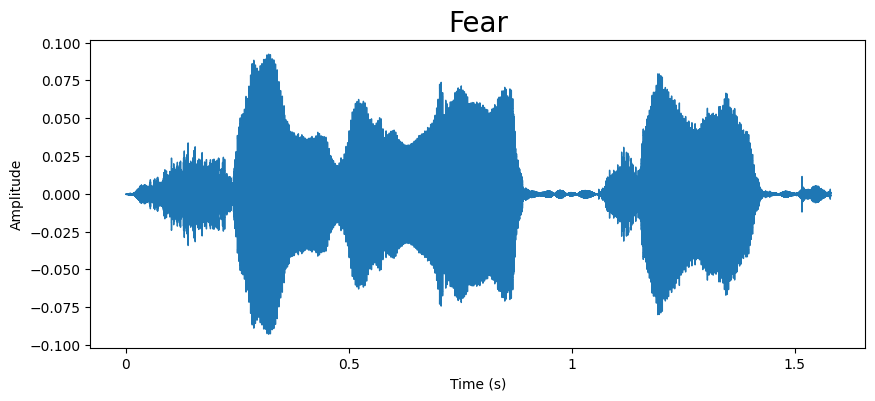

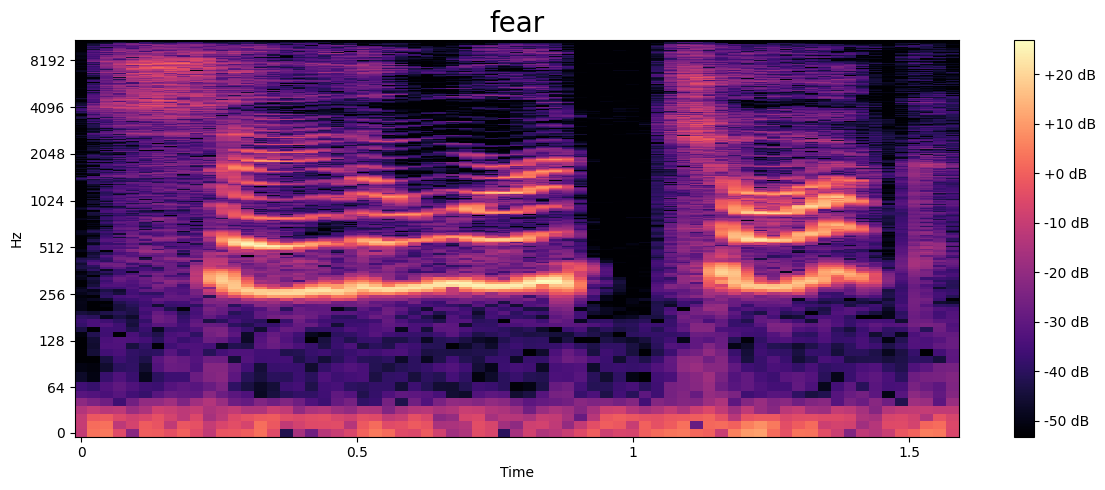

In [267]:
emotion='fear'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sr=librosa.load(path)
waveplot(data,sr,emotion)
spectrogram(data,sr,emotion)
Audio(path)

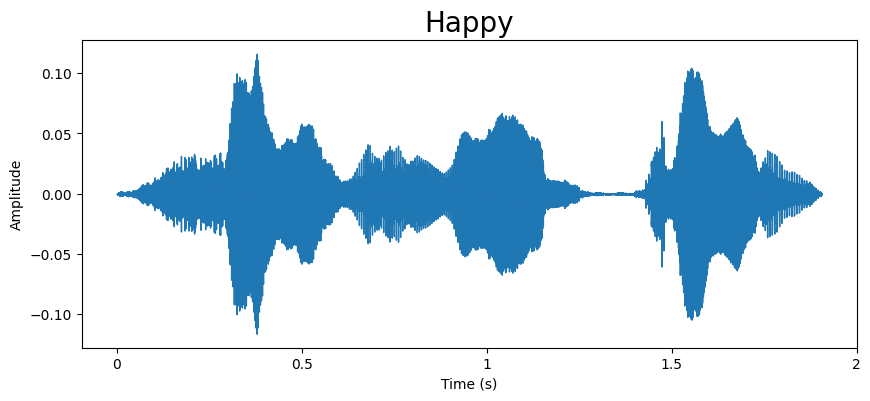

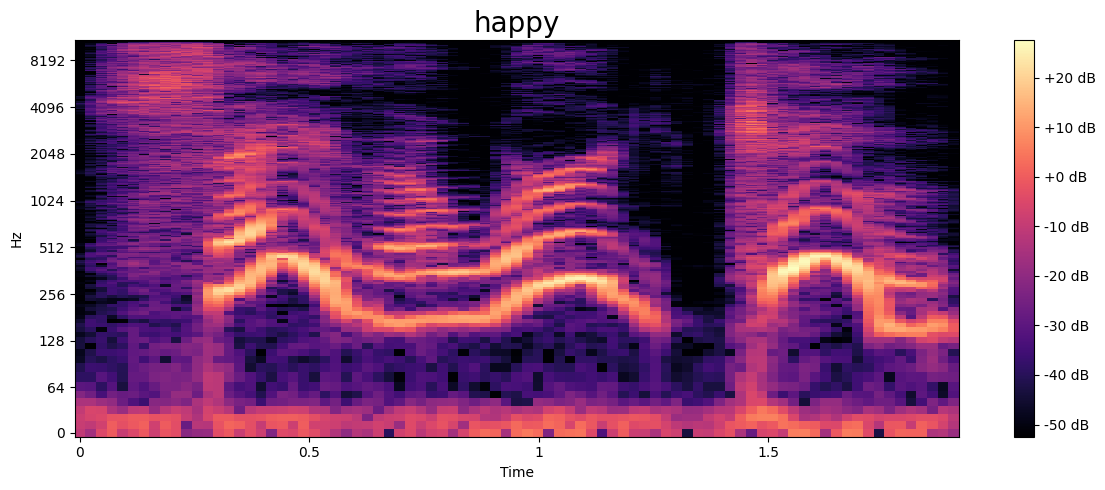

In [268]:
emotion='happy'
path=np.array(df['speech'][df['label']==emotion])[0]
data,sr=librosa.load(path)
waveplot(data,sr,emotion)
spectrogram(data,sr,emotion)
Audio(path)

## A function to extract features from the files

In [269]:
def extract_features(file_path):
    data, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)  # 13 MFCC features
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    return np.hstack((np.mean(mfccs, axis=1), np.mean(chroma, axis=1)))

## Appling feature extraction

In [270]:
df['features'] = df['speech'].apply(extract_features)


In [271]:
df.head()

,speech,label,features
0,/content/TESS Toronto emotional speech set dat...,fear,"[-455.91772, 53.126083, 7.590791, -11.350754, ..."
1,/content/TESS Toronto emotional speech set dat...,fear,"[-433.74445, 61.252625, 23.24382, -5.127514, -..."
2,/content/TESS Toronto emotional speech set dat...,fear,"[-442.81635, 55.097733, 11.641597, -14.879865,..."
3,/content/TESS Toronto emotional speech set dat...,fear,"[-417.44836, 58.760532, 11.220015, -9.722908, ..."
4,/content/TESS Toronto emotional speech set dat...,fear,"[-434.03558, 32.253338, 3.1791852, 13.903306, ..."


## Spliting the dataset

In [272]:
# Convert features to list and labels to NumPy array
X = np.array(df['features'].tolist())
y = np.array(df['label'].tolist())

# Encode the labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model 1: Random Forest Classifier

In [273]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [274]:
def evaluation(model,X_test,y_test):
  y_pred=model.predict(X_test)
  accuracy=accuracy_score(y_test,y_pred)
  print('Accuracy:',accuracy)

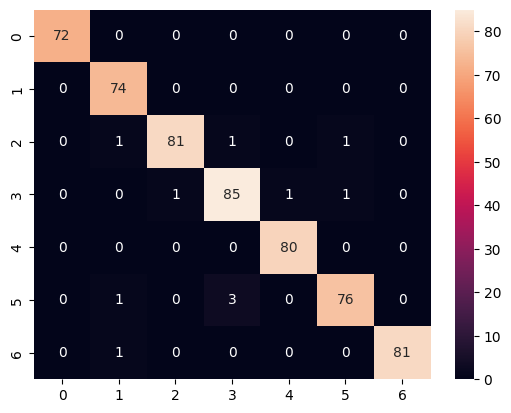

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.96      1.00      0.98        74
           2       0.99      0.96      0.98        84
           3       0.96      0.97      0.96        88
           4       0.99      1.00      0.99        80
           5       0.97      0.95      0.96        80
           6       1.00      0.99      0.99        82

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560



In [275]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = rf_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [276]:
evaluation(rf_model,X_test,y_test)

Accuracy: 0.9803571428571428


## Model 2: SVC

In [277]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [278]:
evaluation(svm_model,X_test,y_test)

Accuracy: 0.8928571428571429


## Model 3: Training using Conv1D

In [279]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3114 - loss: 4.0321 - val_accuracy: 0.6357 - val_loss: 1.1625
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7118 - loss: 0.7693 - val_accuracy: 0.7482 - val_loss: 0.6722
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7968 - loss: 0.5789 - val_accuracy: 0.8464 - val_loss: 0.4456
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8414 - loss: 0.4450 - val_accuracy: 0.8393 - val_loss: 0.4509
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.4301 - val_accuracy: 0.8214 - val_loss: 0.4674
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8634 - loss: 0.3882 - val_accuracy: 0.8250 - val_loss: 0.4655


<Axes: title={'center': 'Accuracy'}>

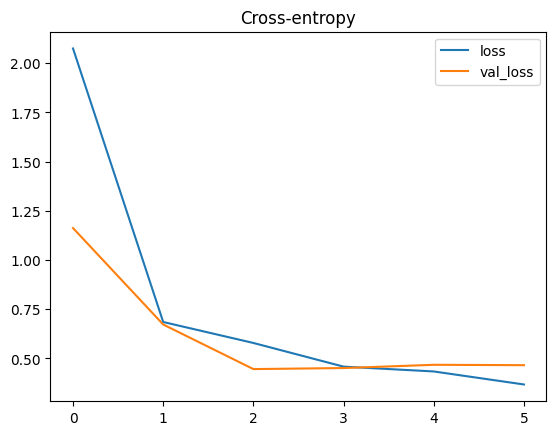

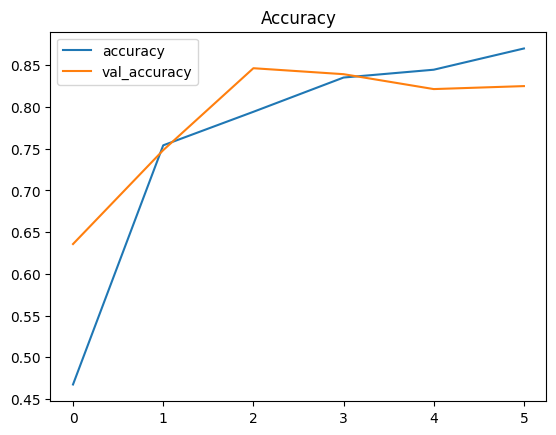

In [280]:
cnn_model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Reshape data for CNN
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# Train the model
history=cnn_model.fit(X_train_cnn,
              y_train,
              epochs=20,
              batch_size=32,
              callbacks=[early_stopping],
              validation_data=(X_test_cnn, y_test))


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")
# # Evaluate CNN
# cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test)
# print('CNN Accuracy:', cnn_acc)


## Ploting the prediction

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


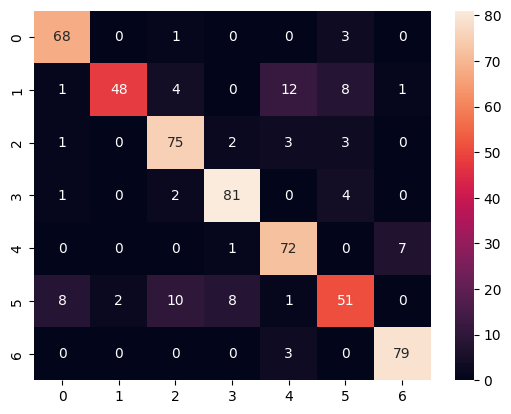

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        72
           1       0.96      0.65      0.77        74
           2       0.82      0.89      0.85        84
           3       0.88      0.92      0.90        88
           4       0.79      0.90      0.84        80
           5       0.74      0.64      0.68        80
           6       0.91      0.96      0.93        82

    accuracy                           0.85       560
   macro avg       0.85      0.84      0.84       560
weighted avg       0.85      0.85      0.84       560



In [281]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [282]:
def predict_emotion(audio_file, model, encoder):
    # Load and preprocess the audio file
    data, sr = librosa.load(audio_file, sr=None)

    # Extract features (same way as you did during training)
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    features = np.hstack((np.mean(mfccs, axis=1), np.mean(chroma, axis=1)))

    # Reshape for the CNN model (adding a new axis for Conv1D)
    features = features[np.newaxis, ..., np.newaxis]

    # Make a prediction
    prediction = model.predict(features)

    # Convert prediction to label
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])

    return predicted_label[0]


In [283]:
predict_emotion('/content/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav',cnn_model,encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


'sad'

## A function for Batch Processing

In [284]:
def batch_predict(audio_files, model, encoder):
    results = {}
    for file in audio_files:
        emotion = predict_emotion(file, model, encoder)
        results[file] = emotion
    return results


In [285]:
# Example usage:
audio_files = df['speech'].sample(5).tolist()  # Predicting emotions for a sample of 5 audio files
predictions = batch_predict(audio_files, cnn_model, encoder)
for file, emotion in predictions.items():
    print(f"Audio file: {file} | Predicted Emotion: {emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Audio file: /content/TESS Toronto emotional speech set data/OAF_happy/OAF_hate_happy.wav | Predicted Emotion: ps
Audio file: /content/TESS Toronto emotional speech set data/YAF_disgust/YAF_late_disgust.wav | Predicted Emotion: neutral
Audio file: /content/TESS Toronto emotional speech set data/YAF_happy/YAF_jail_happy.wav | Predicted Emotion: happy
Audio file: /content/TESS Toronto emotional speech set data/YAF_sad/YAF_mob_sad.wav | Predicted Emotion: sad
Audio file: /content/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_red_ps.wav | Predicted Emotion: ps


## Saving the model

In [286]:
cnn_model.save('emotion_cnn_model.keras')

# Save the LabelEncoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# To load the model and encoder later:
# cnn_model = tf.keras.models.load_model('emotion_cnn_model.h5')
# encoder = pickle.load(open('label_encoder.pkl', 'rb'))
